In [2]:
import pandas as pd
import numpy as np
import os
from huggingface_hub import hf_hub_download
from poi.settings import HF_ORG, HF_TOKEN

# Configuration
target_path = 'NYC'  # 'NYC' or 'TKY'
model_name = 'Nrqvae-NYC-div0.25-commit0.25-lr1e-3'  # Change based on target_path and desired model

# Download codebook CSV from Hugging Face
repo_id = f"{HF_ORG}/{target_path.lower()}"
codebook_filename = f"codebooks-{model_name}.csv"
codebook_hf_path = f"New LLM Dataset/Intermediate Files/{codebook_filename}"

print(f"📥 Downloading codebook from {repo_id}/{codebook_hf_path}")
codebook_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename=codebook_hf_path,
    token=HF_TOKEN
)
codebook = pd.read_csv(codebook_path)
codebook.rename(columns={'Pid': 'poi_id'}, inplace=True)
codebook['Codebook'] = codebook['Codebook'].apply(eval)

# Download poi_info.csv and catname_mapping.csv from Hugging Face
print(f"📥 Downloading poi_info and mappings from {repo_id}")
poi_info_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename="Intermediate Files/poi_info.csv",
    token=HF_TOKEN
)
catname_mapping_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename="Intermediate Files/catname_mapping.csv",
    token=HF_TOKEN
)

# Load poi_info and mappings
poi_info = pd.read_csv(poi_info_path)
catname_mapping = pd.read_csv(catname_mapping_path)

# Create mapping dictionaries (reverse: Mapped_Catname -> Original_Catname)
cat_id_to_name = dict(zip(catname_mapping['Mapped_Catname'], catname_mapping['Original_Catname']))

# Prepare poi_info with renamed columns to match notebook expectations
poi_info_prep = poi_info[['Pid', 'Catname', 'Region']].copy()
poi_info_prep.rename(columns={
    'Pid': 'poi_id',
    'Catname': 'cat_id',  # This is already mapped ID
    'Region': 'region_id'  # This is already mapped ID
}, inplace=True)

# Add original catname using mapping
poi_info_prep['catname'] = poi_info_prep['cat_id'].map(cat_id_to_name)

# Merge codebook with poi_info
codebook = codebook.merge(poi_info_prep[['poi_id', 'cat_id', 'catname', 'region_id']], on='poi_id', how='left')

# 打印 codebook 的前5行，查看数据结构
print("\n📋 Codebook DataFrame 前5行数据:")
print("=" * 80)
print(codebook.head())
print("\n📋 列名:", codebook.columns.tolist())
print("📋 数据形状:", codebook.shape)
print("=" * 80 + "\n")

/Users/clioliang/Desktop/poi/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 Downloading codebook from comp5331poi/nyc/New LLM Dataset/Intermediate Files/codebooks-Nrqvae-NYC-div0.25-commit0.25-lr1e-3.csv
📥 Downloading poi_info and mappings from comp5331poi/nyc

📋 Codebook DataFrame 前5行数据:
   poi_id      Codebook                                             Vector  \
0       1   [12, 31, 5]  [-0.017182789742946625, -0.0173307117074728, 0...   
1       2    [1, 30, 8]  [-0.011606178246438503, 0.13033291697502136, 0...   
2       3  [13, 10, 26]  [0.05948914960026741, 0.10926906764507294, -0....   
3       4  [30, 27, 23]  [0.07547956705093384, 0.11804768443107605, -0....   
4       5  [10, 10, 14]  [0.12534482777118683, 0.10135941207408905, 0.0...   

   cat_id                catname  region_id  
0     140                  CafÃ©         56  
1     132               Tea Room         65  
2      17  Outdoors & Recreation         70  
3      81                 Subway         70  
4     132               Tea Room         70  

📋 列名: ['poi_id', 'Codebook', 'Vector',

In [54]:
# ============================================================================
# 统计 codebook 第一层索引的出现频率（找出出现次数最多的索引）
# ============================================================================
print("\n📊 Codebook 第一层索引出现频率统计:")
print("=" * 60)
first_layer_indices = codebook['Codebook'].apply(lambda x: x[0] if len(x) > 0 else None)
# 按频率排序（出现次数从高到低）
frequency = first_layer_indices.value_counts().sort_values(ascending=False)

print(f"\n✅ 出现次数最多的前50个索引（按频率从高到低排序）:")
for idx, count in frequency.head(50).items():
    print(f"   索引 {idx}: {count:4d} 次")

print(f"\n💡 结论:")
print(f"   总共 {len(frequency)} 个不同的索引值")
print(f"   最常见的索引值: {frequency.index[0]} (出现 {frequency.iloc[0]} 次)")
print("=" * 60 + "\n")

# ============================================================================
# 统计排名前50的每个索引下，出现频率最高的前5个类别
# ============================================================================
print("\n📊 排名前50的每个索引下，出现频率最高的前5个类别:")
print("=" * 80)
top_50_indices = frequency.head(50).index.tolist()
groups_dict = {}

for rank, idx in enumerate(top_50_indices, 1):
    filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
    top_categories = filtered_df['catname'].value_counts().head(5)
    groups_dict[idx] = top_categories.to_dict()
    
    print(f"\n排名 #{rank:2d}: 索引 {idx:2d} (共 {len(filtered_df):3d} 个 POI, 出现 {frequency[idx]:3d} 次)")
    for i, (cat, count) in enumerate(top_categories.items(), 1):
        print(f"    Top {i}: {cat:30s} - {count:3d} 次")

print("\n" + "=" * 80 + "\n")


📊 Codebook 第一层索引出现频率统计:

✅ 出现次数最多的前50个索引（按频率从高到低排序）:
   索引 20:  830 次
   索引 4:  816 次
   索引 26:  739 次
   索引 18:  309 次
   索引 17:  281 次
   索引 6:  161 次
   索引 9:  152 次
   索引 16:  149 次
   索引 0:  123 次
   索引 1:  111 次
   索引 13:  105 次
   索引 30:  102 次
   索引 12:   98 次
   索引 7:   88 次
   索引 27:   81 次
   索引 22:   78 次
   索引 25:   75 次
   索引 2:   74 次
   索引 15:   70 次
   索引 23:   69 次
   索引 14:   68 次
   索引 28:   68 次
   索引 29:   67 次
   索引 3:   67 次
   索引 10:   66 次
   索引 31:   61 次
   索引 5:   60 次
   索引 19:   58 次
   索引 11:   54 次
   索引 21:   29 次
   索引 24:   24 次
   索引 8:    2 次

💡 结论:
   总共 32 个不同的索引值
   最常见的索引值: 20 (出现 830 次)


📊 排名前50的每个索引下，出现频率最高的前5个类别:

排名 # 1: 索引 20 (共 830 个 POI, 出现 830 次)
    Top 1: Office                         - 110 次
    Top 2: Bar                            -  96 次
    Top 3: Coffee Shop                    -  68 次
    Top 4: Gym / Fitness Center           -  56 次
    Top 5: Burger Joint                   -  22 次

排名 # 2: 索引  4 (共 816 个 POI, 出现 816 次)
    

In [ ]:
# ============================================================================
# 随机挑选 4 个索引（threshold：最少出现50次）
# ============================================================================
import random

all_indices = [2, 12, 10, 22, 15, 20, 6, 9, 1, 29, 5, 3, 16, 14, 21, 4, 8, 7, 28, 25]

# random.seed(42)
selected_indices = random.sample(all_indices, k=4)

print("从所有索引中随机挑选的4个索引：")
for idx in selected_indices:
    print(f"索引 {idx}")

从所有索引中随机挑选的4个索引：
索引 21
索引 16
索引 22
索引 2


In [38]:
# 生成 group_1 到 group_4，使用 Cell 2 中随机挑选的索引
# 使用 selected_indices 变量统一管理索引值
idx1, idx2, idx3, idx4 = selected_indices

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1)]
group_1 = filtered_df['catname'].value_counts().head(5)
group_1 = group_1.to_dict()
print(group_1)

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx2)]
group_2 = filtered_df['catname'].value_counts().head(5)
group_2 = group_2.to_dict()
print(group_2)

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx3)]
group_3 = filtered_df['catname'].value_counts().head(5)
group_3 = group_3.to_dict()
print(group_3)

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx4)]
group_4 = filtered_df['catname'].value_counts().head(5)
group_4 = group_4.to_dict()
print(group_4)

{'Office': 51, 'College Academic Building': 8, 'Deli / Bodega': 8, 'Church': 7, 'Gym / Fitness Center': 6}
{'Gym / Fitness Center': 23, 'Bus Station': 18, 'Home (private)': 14, 'Road': 6, 'Train Station': 6}
{'Office': 57, 'Coffee Shop': 45, 'College Academic Building': 11, 'Subway': 11, 'Food & Drink Shop': 7}
{'Office': 83, 'Coffee Shop': 23, 'Building': 11, 'Gym / Fitness Center': 10, 'Medical Center': 9}


['Office', 'Coffee Shop', 'Building', 'Gym / Fitness Center', 'Medical Center', 'College Academic Building', 'Deli / Bodega', 'Church', 'Bus Station', 'Home (private)', 'Road', 'Train Station', 'Subway', 'Food & Drink Shop']


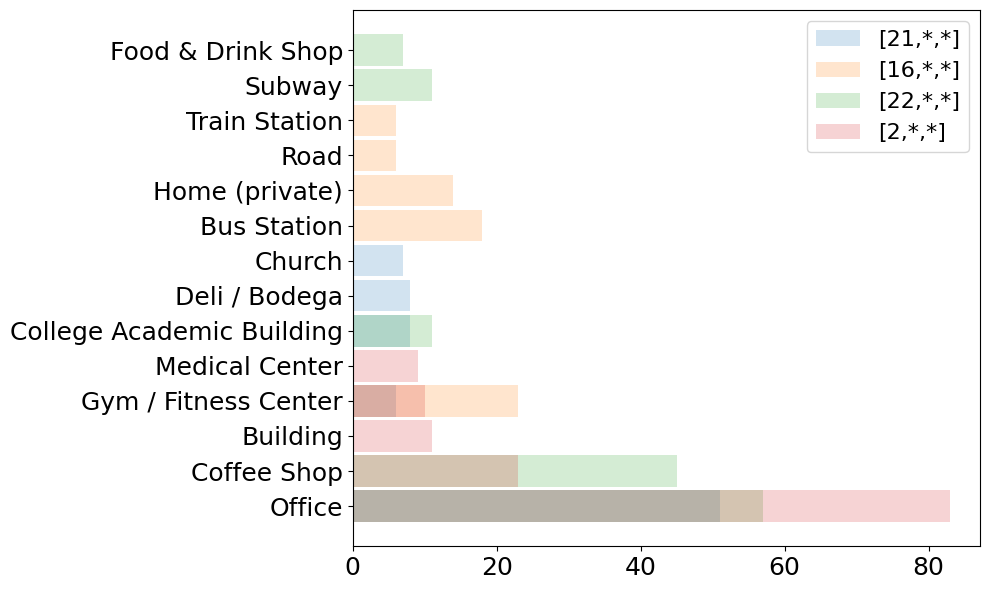

In [ ]:
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = f'output/visualization/{target_path}'
os.makedirs(output_dir, exist_ok=True)

# 确保使用与 Cell 3 相同的索引变量
idx1, idx2, idx3, idx4 = selected_indices

# 合并所有的key
all_keys = []
for group in [group_4, group_1, group_2, group_3]:
    for key in group.keys():
        if key not in all_keys:
            all_keys.append(key)
print(all_keys)
# all_keys = sorted(set(group_1.keys()).union(set(group_2.keys())).union(set(group_3.keys()).union(set(group_4.keys()))))
# all_keys = sorted(set(group_1.keys()).union(set(group_2.keys())).union(set(group_3.keys())))

# 获取每个key在各组中的value（若某key不在某组中，视为0）

group_1_values = [group_1.get(key, 0) for key in all_keys]
group_2_values = [group_2.get(key, 0) for key in all_keys]
group_3_values = [group_3.get(key, 0) for key in all_keys]
group_4_values = [group_4.get(key, 0) for key in all_keys]

# 设置条形图位置
x = np.arange(len(all_keys))

# 设置条形图宽度
bar_width = 0.9
alpha = 0.2
# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每一组的条形图（使用 Cell 3 中的索引变量）
rects1 = ax.barh(x, group_1_values, bar_width, label=f'[{idx1},*,*]', alpha=alpha)
rects2 = ax.barh(x, group_2_values, bar_width, label=f'[{idx2},*,*]', alpha=alpha)
rects3 = ax.barh(x, group_3_values, bar_width, label=f'[{idx3},*,*]', alpha=alpha)
rects4 = ax.barh(x, group_4_values, bar_width, label=f'[{idx4},*,*]', alpha=alpha)

# 添加标签和标题
# ax.set_ylabel('Catname', fontsize=24)
# ax.set_xlabel('Frequency Count', fontsize=24)

ax.set_yticks(x)
ax.set_yticklabels(all_keys, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.legend(fontsize=16)

# 显示图形
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_bar.png', dpi=600)
plt.show()


In [55]:
import random

# 基础索引列表
all_indices = [20, 4, 26, 18, 17, 6, 9, 16, 0, 1, 13, 30, 12, 7, 27, 22, 25, 2, 15, 23]

# 生成10组随机4个索引（每组内无重复，组间可重复）
ten_index_groups = []
for _ in range(10):
    # 每次从all_indices中随机选4个不重复的索引
    selected = random.sample(all_indices, k=4)
    ten_index_groups.append(selected)

# 打印结果（与指定格式一致）
print("ten_index_groups = [")
for group in ten_index_groups:
    print(f"    {group},")
print("]")

ten_index_groups = [
    [1, 22, 13, 26],
    [15, 9, 27, 17],
    [25, 27, 30, 6],
    [13, 16, 26, 17],
    [16, 25, 7, 12],
    [15, 26, 17, 25],
    [9, 7, 20, 12],
    [18, 13, 20, 16],
    [23, 16, 2, 25],
    [30, 16, 27, 23],
]


In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 10组索引（保持原始顺序）
ten_index_groups = [
    [1, 22, 13, 26],
    [15, 9, 27, 17],
    [25, 27, 30, 6],
    [13, 16, 26, 17],
    [16, 25, 7, 12],
    [15, 26, 17, 25],
    [9, 7, 20, 12],
    [18, 13, 20, 16],
    [23, 16, 2, 25],
    [30, 16, 27, 23],
]

# 创建输出目录（确保路径正确，可根据实际情况修改）
output_dir = 'output/visualization'  # 移除了target_path变量，如需保留可自行补充
os.makedirs(output_dir, exist_ok=True)

# 循环处理10组索引
for group_num, selected_indices in enumerate(ten_index_groups, 1):
    # 提取当前组的4个索引
    idx1, idx2, idx3, idx4 = selected_indices
    
    # 1. 计算每组索引的top5类别
    groups = []
    for idx in selected_indices:
        # 筛选当前索引对应的POI
        filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
        # 取top5类别并转为字典
        top5 = filtered_df['catname'].value_counts().head(5).to_dict()
        groups.append(top5)
    group_1, group_2, group_3, group_4 = groups  # 对应4个索引的top5
    
    # 2. 收集所有唯一类别（去重）
    all_keys = []
    for group in [group_1, group_2, group_3, group_4]:
        for key in group.keys():
            if key not in all_keys:
                all_keys.append(key)
    print(f"第{group_num}组 - 总类别数: {len(all_keys)}")
    
    # 3. 准备各组类别的数量（不存在的类别用0填充）
    group_1_values = [group_1.get(key, 0) for key in all_keys]
    group_2_values = [group_2.get(key, 0) for key in all_keys]
    group_3_values = [group_3.get(key, 0) for key in all_keys]
    group_4_values = [group_4.get(key, 0) for key in all_keys]
    
    # 4. 绘制条形图
    x = np.arange(len(all_keys))  # 类别数量作为y轴刻度
    bar_width = 0.9
    alpha = 0.2  # 透明度
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 绘制4个索引的条形图，标签显示对应的索引
    ax.barh(x, group_1_values, bar_width, label=f'[{idx1},*,*]', alpha=alpha)
    ax.barh(x, group_2_values, bar_width, label=f'[{idx2},*,*]', alpha=alpha)
    ax.barh(x, group_3_values, bar_width, label=f'[{idx3},*,*]', alpha=alpha)
    ax.barh(x, group_4_values, bar_width, label=f'[{idx4},*,*]', alpha=alpha)
    
    # 设置坐标轴和标签
    ax.set_yticks(x)
    ax.set_yticklabels(all_keys, fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')  # 图例放右侧避免遮挡
    
    # 调整布局并保存
    plt.tight_layout()
    # 文件名包含组号和索引，例如：group_1_56-2-34-46.png
    index_str = "-".join(map(str, selected_indices))
    save_path = f"{output_dir}/group_{group_num}_{index_str}_bar.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')  # 确保图例完整保存
    plt.close()  # 关闭当前图，释放内存
    
    print(f"第{group_num}组图已保存至: {save_path}")

print("10组条形图已全部生成！")

第1组 - 总类别数: 11
第1组图已保存至: output/visualization/group_1_1-22-13-26_bar.png
第2组 - 总类别数: 15
第2组图已保存至: output/visualization/group_2_15-9-27-17_bar.png
第3组 - 总类别数: 14
第3组图已保存至: output/visualization/group_3_25-27-30-6_bar.png
第4组 - 总类别数: 15
第4组图已保存至: output/visualization/group_4_13-16-26-17_bar.png
第5组 - 总类别数: 9
第5组图已保存至: output/visualization/group_5_16-25-7-12_bar.png
第6组 - 总类别数: 16
第6组图已保存至: output/visualization/group_6_15-26-17-25_bar.png
第7组 - 总类别数: 8
第7组图已保存至: output/visualization/group_7_9-7-20-12_bar.png
第8组 - 总类别数: 13
第8组图已保存至: output/visualization/group_8_18-13-20-16_bar.png
第9组 - 总类别数: 10
第9组图已保存至: output/visualization/group_9_23-16-2-25_bar.png
第10组 - 总类别数: 11
第10组图已保存至: output/visualization/group_10_30-16-27-23_bar.png
10组条形图已全部生成！


In [57]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# # Use the same codebook data loaded in Cell 0
# # codebook is already loaded and merged with poi_info

# # 使用 Cell 2 中随机选择的索引
# selected_indices = [29, 37, 18, 13]

# # Prepare filtered data
# # 检查 Vector 列是否已经是列表类型，避免重复 eval
# if isinstance(codebook['Vector'].iloc[0], str):
#     codebook['Vector'] = codebook['Vector'].apply(eval)
# # 使用 selected_indices 中的4个索引
# filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1 or x[0] == idx2 or x[0] == idx3 or x[0] == idx4)] 
# print(f"使用索引 {selected_indices}, 共 {len(filtered_df)} 个 POI")

# # 自动从四个索引的 top 5 类别中收集所有类别（去重）
# all_keys = []
# for idx in selected_indices:
#     idx_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
#     top_cats = idx_df['catname'].value_counts().head(5).index.tolist()
#     for cat in top_cats:
#         if cat not in all_keys:
#             all_keys.append(cat)
# print(f"自动收集到 {len(all_keys)} 个类别: {all_keys}")

# filtered_df = filtered_df[['catname', 'Vector']]
# filtered_df = filtered_df[filtered_df['catname'].isin(all_keys)]
# print(len(filtered_df))

# # 将 `Vector` 列转化为numpy数组，便于t-SNE处理
# vectors = np.array(filtered_df['Vector'].to_list())

# # 使用t-SNE进行降维到2维
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(vectors)

# # 将降维后的结果添加到DataFrame中
# filtered_df['tsne_1'] = tsne_results[:, 0]
# filtered_df['tsne_2'] = tsne_results[:, 1]

# # 颜色按照类别排序逐渐变化
# # 将类别映射到指定顺序并生成颜色
# sorted_df = filtered_df[filtered_df['catname'].isin(all_keys)].copy()
# sorted_df['catname'] = pd.Categorical(sorted_df['catname'], categories=all_keys, ordered=True)
# sorted_df.sort_values('catname', inplace=True)

# # 使用渐变调色板
# num_categories = len(all_keys)
# palette = sns.color_palette("viridis", num_categories)  # 你可以改为 "plasma", "coolwarm" 等渐变调色板

# # 绘制 t-SNE 可视化
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.scatterplot(
#     data=sorted_df,
#     x='tsne_1',
#     y='tsne_2',
#     hue='catname',
#     palette=palette,
#     s=100,
#     alpha=0.8,
#     ax=ax
# )
# # plt.title('t-SNE Visualization with Gradual Color Transition', fontsize=16)
# ax.set_xlabel('') # 显示设置为空字符串 t-SNE 1
# ax.set_ylabel('') # t-SNE 2
# ax.legend(title='Category', bbox_to_anchor=(-0.05, 1), loc='upper right', fontsize=10) #（1.05, 1）
# ax.tick_params(axis='y', labelsize=14)  
# ax.tick_params(axis='x', labelsize=14)
# plt.tight_layout()
# plt.savefig(f'{output_dir}/semitic_tsne.png', dpi=600)
# plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# ===================== 配置参数 =====================
# 10组索引（保持你提供的原始顺序）
ten_index_groups = [
    [1, 22, 13, 26],
    [15, 9, 27, 17],
    [25, 27, 30, 6],
    [13, 16, 26, 17],
    [16, 25, 7, 12],
    [15, 26, 17, 25],
    [9, 7, 20, 12],
    [18, 13, 20, 16],
    [23, 16, 2, 25],
    [30, 16, 27, 23],
]

# 输出文件夹（不存在则创建）
output_dir = "tsne_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 检查Vector列格式（确保是列表类型）
if isinstance(codebook['Vector'].iloc[0], str):
    codebook['Vector'] = codebook['Vector'].apply(eval)

# ===================== 批量生成10张图 =====================
for group_idx, selected_indices in enumerate(ten_index_groups, 1):
    # 1. 筛选当前组索引对应的POI（第一个码元匹配任意一个索引）
    filtered_df = codebook[codebook['Codebook'].apply(
        lambda x: x[0] in selected_indices  # 简化判断逻辑，无需逐个写or
    )]
    print(f"第{group_idx}组 - 使用索引 {selected_indices}, 共 {len(filtered_df)} 个 POI")

    # 2. 自动收集当前组的top5类别（去重）
    all_keys = []
    for idx in selected_indices:
        idx_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
        top_cats = idx_df['catname'].value_counts().head(5).index.tolist()
        all_keys.extend([cat for cat in top_cats if cat not in all_keys])
    print(f"第{group_idx}组 - 自动收集到 {len(all_keys)} 个类别")

    # 3. 过滤仅包含目标类别的数据
    filtered_df = filtered_df[['catname', 'Vector']]
    filtered_df = filtered_df[filtered_df['catname'].isin(all_keys)].reset_index(drop=True)
    if len(filtered_df) == 0:
        print(f"第{group_idx}组无有效数据，跳过")
        continue

    # 4. t-SNE降维（每组使用相同随机种子保证可复现）
    vectors = np.array(filtered_df['Vector'].to_list())
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(vectors)
    filtered_df['tsne_1'] = tsne_results[:, 0]
    filtered_df['tsne_2'] = tsne_results[:, 1]

    # 5. 类别排序与颜色配置
    filtered_df['catname'] = pd.Categorical(filtered_df['catname'], categories=all_keys, ordered=True)
    num_categories = len(all_keys)
    palette = sns.color_palette("viridis", num_categories)  # 渐变调色板

    # 6. 绘制并保存图
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        data=filtered_df,
        x='tsne_1',
        y='tsne_2',
        hue='catname',
        palette=palette,
        s=100,
        alpha=0.8,
        ax=ax
    )
    # 设置标题（标注组号和索引，便于识别）
    ax.set_title(f'Group {group_idx} - SID Prefixes {selected_indices}', fontsize=14, pad=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # 图例位置优化（避免遮挡）
    ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.tick_params(axis='both', labelsize=14)
    plt.tight_layout()  # 自动调整布局，防止图例被截断

    # 保存图片（文件名包含组号和索引，便于区分）
    index_str = "-".join(map(str, selected_indices))
    save_path = f"{output_dir}/tsne_group_{group_idx}_indices_{index_str}.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')  # bbox_inches避免图例被裁掉
    plt.close()  # 关闭当前图，释放内存
    print(f"第{group_idx}组图已保存至: {save_path}\n")

print("10组t-SNE图已全部生成完成！")

第1组 - 使用索引 [1, 22, 13, 26], 共 1033 个 POI
第1组 - 自动收集到 11 个类别
第1组图已保存至: tsne_plots/tsne_group_1_indices_1-22-13-26.png

第2组 - 使用索引 [15, 9, 27, 17], 共 584 个 POI
第2组 - 自动收集到 15 个类别
第2组图已保存至: tsne_plots/tsne_group_2_indices_15-9-27-17.png

第3组 - 使用索引 [25, 27, 30, 6], 共 419 个 POI
第3组 - 自动收集到 14 个类别
第3组图已保存至: tsne_plots/tsne_group_3_indices_25-27-30-6.png

第4组 - 使用索引 [13, 16, 26, 17], 共 1274 个 POI
第4组 - 自动收集到 15 个类别
第4组图已保存至: tsne_plots/tsne_group_4_indices_13-16-26-17.png

第5组 - 使用索引 [16, 25, 7, 12], 共 410 个 POI
第5组 - 自动收集到 9 个类别
第5组图已保存至: tsne_plots/tsne_group_5_indices_16-25-7-12.png

第6组 - 使用索引 [15, 26, 17, 25], 共 1165 个 POI
第6组 - 自动收集到 16 个类别
第6组图已保存至: tsne_plots/tsne_group_6_indices_15-26-17-25.png

第7组 - 使用索引 [9, 7, 20, 12], 共 1168 个 POI
第7组 - 自动收集到 8 个类别
第7组图已保存至: tsne_plots/tsne_group_7_indices_9-7-20-12.png

第8组 - 使用索引 [18, 13, 20, 16], 共 1393 个 POI
第8组 - 自动收集到 13 个类别
第8组图已保存至: tsne_plots/tsne_group_8_indices_18-13-20-16.png

第9组 - 使用索引 [23, 16, 2, 25], 共 367 个 POI
第9组 - 自动收集到 10 个类

# 第二层 Prefix 对 Region 的分析

分析 codebook 第二层索引（x[1]）与 region_id 的关系

In [3]:
# ============================================================================
# 统计 codebook 第二层索引的出现频率（找出出现次数最多的索引）
# ============================================================================
print("\n📊 Codebook 第二层索引出现频率统计:")
print("=" * 60)
second_layer_indices = codebook['Codebook'].apply(lambda x: x[1] if len(x) > 1 else None)
# 按频率排序（出现次数从高到低）
frequency = second_layer_indices.value_counts().sort_values(ascending=False)

print(f"\n✅ 出现次数最多的前50个索引（按频率从高到低排序）:")
for idx, count in frequency.head(50).items():
    print(f"   索引 {idx}: {count:4d} 次")

print(f"\n💡 结论:")
print(f"   总共 {len(frequency)} 个不同的索引值")
print(f"   最常见的索引值: {frequency.index[0]} (出现 {frequency.iloc[0]} 次)")
print("=" * 60 + "\n")

# ============================================================================
# 统计排名前50的每个索引下，出现频率最高的前5个region
# ============================================================================
print("\n📊 排名前50的每个索引下，出现频率最高的前5个region:")
print("=" * 80)
top_50_indices = frequency.head(50).index.tolist()
groups_dict_region = {}

for rank, idx in enumerate(top_50_indices, 1):
    filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[1] == idx if len(x) > 1 else False)]
    top_regions = filtered_df['region_id'].value_counts().head(5)
    groups_dict_region[idx] = top_regions.to_dict()
    
    print(f"\n排名 #{rank:2d}: 索引 {idx:2d} (共 {len(filtered_df):3d} 个 POI, 出现 {frequency[idx]:3d} 次)")
    for i, (region, count) in enumerate(top_regions.items(), 1):
        print(f"    Top {i}: Region {region:3d} - {count:3d} 次")

print("\n" + "=" * 80 + "\n")



📊 Codebook 第二层索引出现频率统计:

✅ 出现次数最多的前50个索引（按频率从高到低排序）:
   索引 30:  347 次
   索引 24:  239 次
   索引 26:  202 次
   索引 17:  200 次
   索引 22:  198 次
   索引 8:  196 次
   索引 3:  186 次
   索引 1:  185 次
   索引 10:  179 次
   索引 14:  174 次
   索引 20:  173 次
   索引 31:  171 次
   索引 9:  170 次
   索引 12:  166 次
   索引 13:  162 次
   索引 21:  161 次
   索引 16:  155 次
   索引 11:  153 次
   索引 4:  152 次
   索引 19:  148 次
   索引 29:  145 次
   索引 27:  142 次
   索引 25:  129 次
   索引 18:  128 次
   索引 6:  120 次
   索引 0:  118 次
   索引 23:  118 次
   索引 5:  118 次
   索引 15:  106 次
   索引 28:  102 次
   索引 7:   98 次
   索引 2:   94 次

💡 结论:
   总共 32 个不同的索引值
   最常见的索引值: 30 (出现 347 次)


📊 排名前50的每个索引下，出现频率最高的前5个region:

排名 # 1: 索引 30 (共 347 个 POI, 出现 347 次)
    Top 1: Region  70 -  65 次
    Top 2: Region  65 -  56 次
    Top 3: Region  56 -  22 次
    Top 4: Region  60 -  20 次
    Top 5: Region  28 -  17 次

排名 # 2: 索引 24 (共 239 个 POI, 出现 239 次)
    Top 1: Region  70 -  47 次
    Top 2: Region  65 -  33 次
    Top 3: Region  56 -  29 次
    Top 4:

In [9]:
# ============================================================================
# 随机挑选 4 个第二层索引（threshold：最少出现50次）
# ============================================================================
import random

# 筛选出现次数>=50的索引
frequent_indices = [idx for idx, count in frequency.items() if count >= 50]

# random.seed(42)  # 取消注释可固定随机结果
selected_indices_layer2 = random.sample(frequent_indices, k=4)

print("从第二层索引中随机挑选的4个索引（用于region分析）：")
for idx in selected_indices_layer2:
    print(f"索引 {idx}")

# 生成 group_1 到 group_4，使用 selected_indices_layer2 中随机挑选的索引
idx1, idx2, idx3, idx4 = selected_indices_layer2

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[1] == idx1 if len(x) > 1 else False)]
group_1_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"\n索引 {idx1} 的 top5 regions: {group_1_region}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[1] == idx2 if len(x) > 1 else False)]
group_2_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"索引 {idx2} 的 top5 regions: {group_2_region}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[1] == idx3 if len(x) > 1 else False)]
group_3_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"索引 {idx3} 的 top5 regions: {group_3_region}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[1] == idx4 if len(x) > 1 else False)]
group_4_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"索引 {idx4} 的 top5 regions: {group_4_region}")


从第二层索引中随机挑选的4个索引（用于region分析）：
索引 12
索引 24
索引 0
索引 10

索引 12 的 top5 regions: {65: 45, 70: 39, 56: 13, 43: 7, 28: 6}
索引 24 的 top5 regions: {70: 47, 65: 33, 56: 29, 28: 10, 5: 9}
索引 0 的 top5 regions: {65: 18, 43: 9, 70: 8, 73: 7, 56: 6}
索引 10 的 top5 regions: {65: 49, 70: 28, 56: 17, 28: 8, 60: 8}


共 8 个不同的 regions: [65, 70, 56, 28, 60, 43, 5, 73]


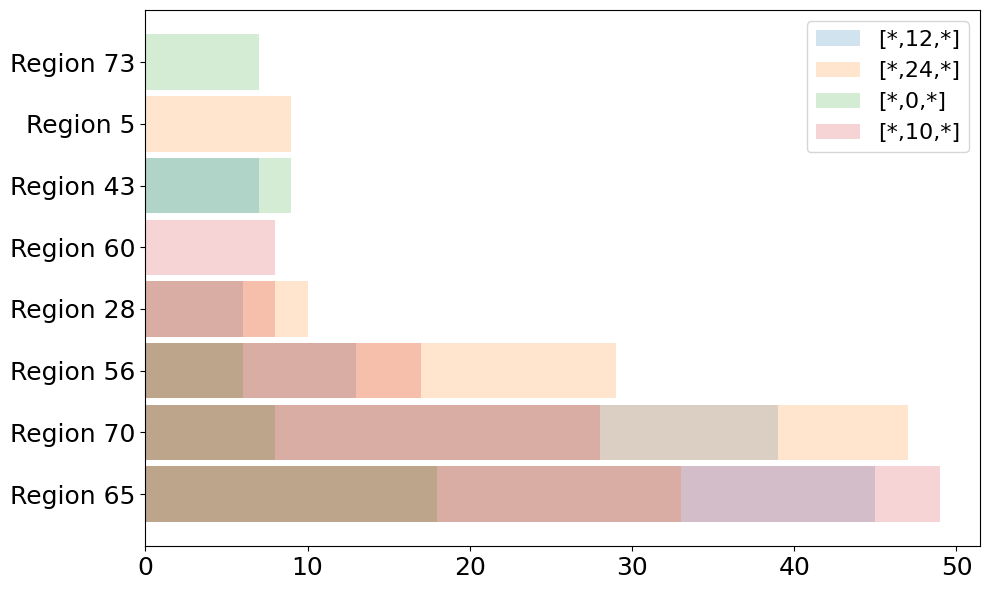

In [10]:
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = f'output/visualization/{target_path}'
os.makedirs(output_dir, exist_ok=True)

# 确保使用与上一个 Cell 相同的索引变量
idx1, idx2, idx3, idx4 = selected_indices_layer2

# 合并所有的region keys
all_region_keys = []
for group in [group_4_region, group_1_region, group_2_region, group_3_region]:
    for key in group.keys():
        if key not in all_region_keys:
            all_region_keys.append(key)
print(f"共 {len(all_region_keys)} 个不同的 regions: {all_region_keys}")

# 获取每个region在各组中的value（若某region不在某组中，视为0）
group_1_values = [group_1_region.get(key, 0) for key in all_region_keys]
group_2_values = [group_2_region.get(key, 0) for key in all_region_keys]
group_3_values = [group_3_region.get(key, 0) for key in all_region_keys]
group_4_values = [group_4_region.get(key, 0) for key in all_region_keys]

# 设置条形图位置
x = np.arange(len(all_region_keys))

# 设置条形图宽度和透明度
bar_width = 0.9
alpha = 0.2

# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每一组的条形图（使用第二层索引变量）
rects1 = ax.barh(x, group_1_values, bar_width, label=f'[*,{idx1},*]', alpha=alpha)
rects2 = ax.barh(x, group_2_values, bar_width, label=f'[*,{idx2},*]', alpha=alpha)
rects3 = ax.barh(x, group_3_values, bar_width, label=f'[*,{idx3},*]', alpha=alpha)
rects4 = ax.barh(x, group_4_values, bar_width, label=f'[*,{idx4},*]', alpha=alpha)

# 添加标签和标题
ax.set_yticks(x)
ax.set_yticklabels([f"Region {r}" for r in all_region_keys], fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.legend(fontsize=16)

# 显示图形
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_bar_region.png', dpi=600)
plt.show()


使用第二层索引 [16, 17, 8, 29], 共 696 个 POI
自动收集到 8 个 regions: [65, 70, 56, 28, 73, 43, 12, 76]
过滤后剩余 439 个POI


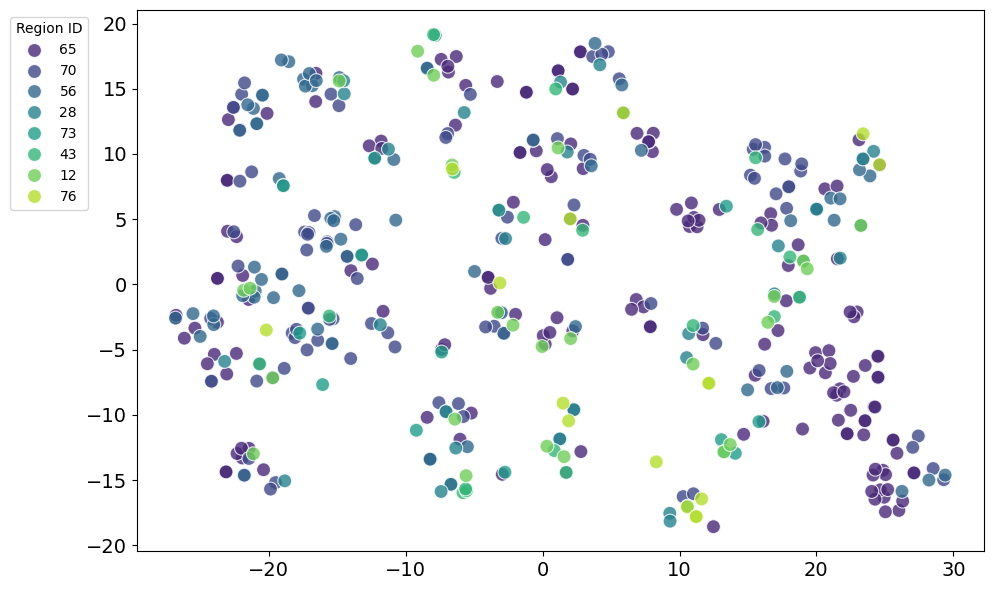

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 使用随机选择的第二层索引
selected_indices = selected_indices_layer2

# 检查 Vector 列是否已经是列表类型，避免重复 eval
if isinstance(codebook['Vector'].iloc[0], str):
    codebook['Vector'] = codebook['Vector'].apply(eval)

# 使用 selected_indices 中的4个第二层索引
filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and (x[1] == idx1 or x[1] == idx2 or x[1] == idx3 or x[1] == idx4)
)] 
print(f"使用第二层索引 {selected_indices}, 共 {len(filtered_df)} 个 POI")

# 自动从四个第二层索引的 top 5 regions 中收集所有region（去重）
all_region_keys = []
for idx in selected_indices:
    idx_df = codebook[codebook['Codebook'].apply(lambda x: len(x) > 1 and x[1] == idx)]
    top_regions = idx_df['region_id'].value_counts().head(5).index.tolist()
    for region in top_regions:
        if region not in all_region_keys:
            all_region_keys.append(region)
print(f"自动收集到 {len(all_region_keys)} 个 regions: {all_region_keys}")

filtered_df = filtered_df[['region_id', 'Vector']]
filtered_df = filtered_df[filtered_df['region_id'].isin(all_region_keys)]
print(f"过滤后剩余 {len(filtered_df)} 个POI")

# 将 `Vector` 列转化为numpy数组，便于t-SNE处理
vectors = np.array(filtered_df['Vector'].to_list())

# 使用t-SNE进行降维到2维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectors)

# 将降维后的结果添加到DataFrame中
filtered_df['tsne_1'] = tsne_results[:, 0]
filtered_df['tsne_2'] = tsne_results[:, 1]

# 将 region_id 映射到指定顺序并生成颜色
sorted_df = filtered_df[filtered_df['region_id'].isin(all_region_keys)].copy()
sorted_df['region_id'] = pd.Categorical(sorted_df['region_id'], categories=all_region_keys, ordered=True)
sorted_df.sort_values('region_id', inplace=True)

# 使用渐变调色板
num_regions = len(all_region_keys)
palette = sns.color_palette("viridis", num_regions)

# 绘制 t-SNE 可视化
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=sorted_df,
    x='tsne_1',
    y='tsne_2',
    hue='region_id',
    palette=palette,
    s=100,
    alpha=0.8,
    ax=ax
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(title='Region ID', bbox_to_anchor=(-0.05, 1), loc='upper right', fontsize=10)
ax.tick_params(axis='y', labelsize=14)  
ax.tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_tsne_region.png', dpi=600)
plt.show()


# 前两层 Prefix 组合对 Category 的分析

分析 codebook 前两层索引组合（[x[0], x[1]]）与 catname 的关系


In [5]:
# ============================================================================
# 统计 codebook 前两层索引组合的出现频率
# ============================================================================
print("\n📊 Codebook 前两层索引组合出现频率统计:")
print("=" * 60)

# 提取前两层索引组合为元组 (first, second)
two_layer_combo = codebook['Codebook'].apply(
    lambda x: (x[0], x[1]) if len(x) > 1 else None
)

# 按频率排序（出现次数从高到低）
frequency_combo = two_layer_combo.value_counts().sort_values(ascending=False)

print(f"\n✅ 出现次数最多的前30个索引组合（按频率从高到低排序）:")
for combo, count in frequency_combo.head(30).items():
    if combo:  # 确保不是None
        print(f"   组合 [{combo[0]:2d}, {combo[1]:2d}]: {count:4d} 次")

print(f"\n💡 结论:")
print(f"   总共 {len(frequency_combo)} 个不同的索引组合")
if len(frequency_combo) > 0 and frequency_combo.index[0] is not None:
    top_combo = frequency_combo.index[0]
    print(f"   最常见的组合: [{top_combo[0]}, {top_combo[1]}] (出现 {frequency_combo.iloc[0]} 次)")
print("=" * 60 + "\n")

# ============================================================================
# 统计排名前30的每个组合下，出现频率最高的前5个category
# ============================================================================
print("\n📊 排名前30的每个组合下，出现频率最高的前5个category:")
print("=" * 80)
top_30_combos = [c for c in frequency_combo.head(30).index.tolist() if c is not None]
groups_dict_combo = {}

for rank, combo in enumerate(top_30_combos, 1):
    filtered_df = codebook[codebook['Codebook'].apply(
        lambda x: len(x) > 1 and x[0] == combo[0] and x[1] == combo[1]
    )]
    top_categories = filtered_df['catname'].value_counts().head(5)
    groups_dict_combo[combo] = top_categories.to_dict()
    
    print(f"\n排名 #{rank:2d}: 组合 [{combo[0]:2d}, {combo[1]:2d}] (共 {len(filtered_df):3d} 个 POI, 出现 {frequency_combo[combo]:3d} 次)")
    for i, (cat, count) in enumerate(top_categories.items(), 1):
        print(f"    Top {i}: {cat:30s} - {count:3d} 次")

print("\n" + "=" * 80 + "\n")



📊 Codebook 前两层索引组合出现频率统计:

✅ 出现次数最多的前30个索引组合（按频率从高到低排序）:
   组合 [ 2, 30]:   36 次
   组合 [22, 10]:   34 次
   组合 [12, 30]:   32 次
   组合 [12, 24]:   31 次
   组合 [ 5, 30]:   28 次
   组合 [20, 24]:   25 次
   组合 [20,  8]:   24 次
   组合 [22, 12]:   22 次
   组合 [16, 30]:   22 次
   组合 [29, 30]:   22 次
   组合 [ 9, 26]:   21 次
   组合 [16, 24]:   20 次
   组合 [ 2, 26]:   20 次
   组合 [ 2, 17]:   20 次
   组合 [15, 31]:   19 次
   组合 [20, 13]:   19 次
   组合 [ 6, 30]:   19 次
   组合 [ 9,  1]:   19 次
   组合 [10, 12]:   19 次
   组合 [21, 30]:   18 次
   组合 [20,  9]:   18 次
   组合 [22, 16]:   18 次
   组合 [12, 11]:   17 次
   组合 [ 2, 20]:   17 次
   组合 [ 8, 30]:   17 次
   组合 [29,  3]:   16 次
   组合 [22,  8]:   16 次
   组合 [10, 26]:   16 次
   组合 [ 3, 12]:   16 次
   组合 [22, 22]:   15 次

💡 结论:
   总共 946 个不同的索引组合
   最常见的组合: [2, 30] (出现 36 次)


📊 排名前30的每个组合下，出现频率最高的前5个category:

排名 # 1: 组合 [ 2, 30] (共  36 个 POI, 出现  36 次)
    Top 1: Office                         -   4 次
    Top 2: Bagel Shop                     -   3 次
    Top 3: Road 

In [6]:
# ============================================================================
# 随机挑选 4 个前两层索引组合（threshold：最少出现30次）
# ============================================================================
import random

# 筛选出现次数>=30的组合
frequent_combos = [combo for combo, count in frequency_combo.items() 
                   if combo is not None and count >= 18]

# random.seed(42)  # 取消注释可固定随机结果
selected_combos = random.sample(frequent_combos, k=4)

print("从前两层索引组合中随机挑选的4个组合（用于category分析）：")
for combo in selected_combos:
    print(f"组合 [{combo[0]}, {combo[1]}]")

# 生成 group_1 到 group_4，使用 selected_combos 中随机挑选的组合
combo1, combo2, combo3, combo4 = selected_combos

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo1[0] and x[1] == combo1[1]
)]
group_1_combo = filtered_df['catname'].value_counts().head(5).to_dict()
print(f"\n组合 [{combo1[0]}, {combo1[1]}] 的 top5 categories: {group_1_combo}")

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo2[0] and x[1] == combo2[1]
)]
group_2_combo = filtered_df['catname'].value_counts().head(5).to_dict()
print(f"组合 [{combo2[0]}, {combo2[1]}] 的 top5 categories: {group_2_combo}")

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo3[0] and x[1] == combo3[1]
)]
group_3_combo = filtered_df['catname'].value_counts().head(5).to_dict()
print(f"组合 [{combo3[0]}, {combo3[1]}] 的 top5 categories: {group_3_combo}")

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo4[0] and x[1] == combo4[1]
)]
group_4_combo = filtered_df['catname'].value_counts().head(5).to_dict()
print(f"组合 [{combo4[0]}, {combo4[1]}] 的 top5 categories: {group_4_combo}")


从前两层索引组合中随机挑选的4个组合（用于category分析）：
组合 [9, 1]
组合 [20, 9]
组合 [10, 12]
组合 [20, 8]

组合 [9, 1] 的 top5 categories: {'Gym / Fitness Center': 3, 'Department Store': 2, 'General College & University': 1, 'Burger Joint': 1, 'Other Great Outdoors': 1}
组合 [20, 9] 的 top5 categories: {'Bar': 14, 'Deli / Bodega': 1, 'Falafel Restaurant': 1, 'Cuban Restaurant': 1, 'Music Venue': 1}
组合 [10, 12] 的 top5 categories: {'Bar': 4, 'Electronics Store': 2, 'Mexican Restaurant': 2, 'Pizza Place': 1, 'Office': 1}
组合 [20, 8] 的 top5 categories: {'Bar': 20, 'Music Venue': 1, 'Hotel': 1, 'Hot Dog Joint': 1, 'Drugstore / Pharmacy': 1}


共 17 个不同的 categories: ['CafÃ©', 'Gym / Fitness Center', 'Bar', 'Bus Station', 'Building', 'Coffee Shop', 'Clothing Store', 'Department Store', 'Mall', 'Electronics Store', 'Mexican Restaurant', 'Pizza Place', 'Office', 'Music Venue', 'Hotel', 'Hot Dog Joint', 'Drugstore / Pharmacy']


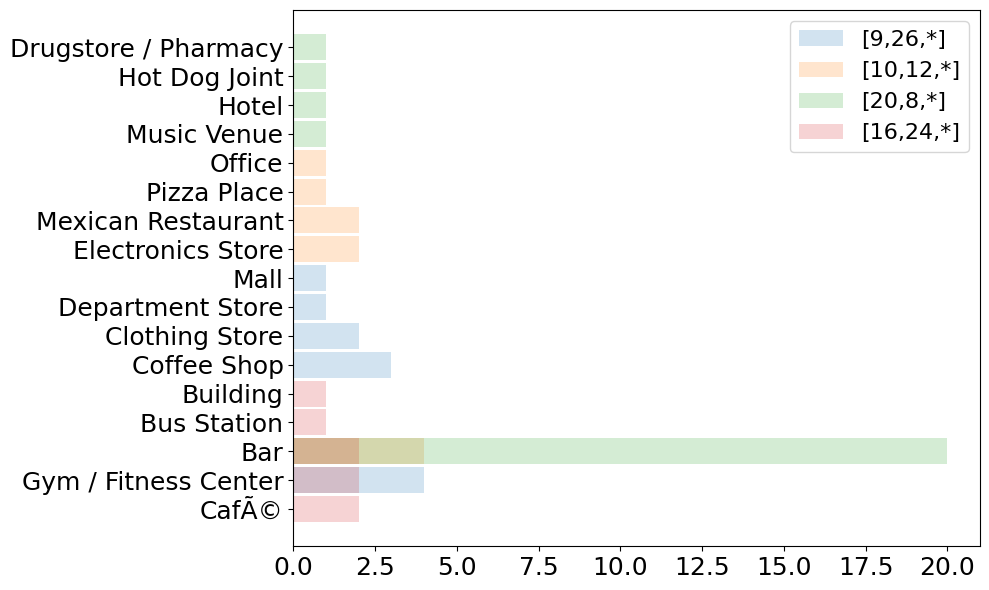

In [35]:
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = f'output/visualization/{target_path}'
os.makedirs(output_dir, exist_ok=True)

# 确保使用与上一个 Cell 相同的组合变量
combo1, combo2, combo3, combo4 = selected_combos

# 合并所有的category keys
all_cat_keys = []
for group in [group_4_combo, group_1_combo, group_2_combo, group_3_combo]:
    for key in group.keys():
        if key not in all_cat_keys:
            all_cat_keys.append(key)
print(f"共 {len(all_cat_keys)} 个不同的 categories: {all_cat_keys}")

# 获取每个category在各组中的value（若某category不在某组中，视为0）
group_1_values = [group_1_combo.get(key, 0) for key in all_cat_keys]
group_2_values = [group_2_combo.get(key, 0) for key in all_cat_keys]
group_3_values = [group_3_combo.get(key, 0) for key in all_cat_keys]
group_4_values = [group_4_combo.get(key, 0) for key in all_cat_keys]

# 设置条形图位置
x = np.arange(len(all_cat_keys))

# 设置条形图宽度和透明度
bar_width = 0.9
alpha = 0.2

# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每一组的条形图（使用前两层索引组合）
rects1 = ax.barh(x, group_1_values, bar_width, label=f'[{combo1[0]},{combo1[1]},*]', alpha=alpha)
rects2 = ax.barh(x, group_2_values, bar_width, label=f'[{combo2[0]},{combo2[1]},*]', alpha=alpha)
rects3 = ax.barh(x, group_3_values, bar_width, label=f'[{combo3[0]},{combo3[1]},*]', alpha=alpha)
rects4 = ax.barh(x, group_4_values, bar_width, label=f'[{combo4[0]},{combo4[1]},*]', alpha=alpha)

# 添加标签和标题
ax.set_yticks(x)
ax.set_yticklabels(all_cat_keys, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.legend(fontsize=16)

# 显示图形
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_bar_cat_combo.png', dpi=600)
plt.show()


使用前两层索引组合 [(2, 30), (12, 24), (22, 10), (12, 30)], 共 133 个 POI
自动收集到 13 个 categories: ['Office', 'Bagel Shop', 'Road', 'Coffee Shop', 'School', 'Medical Center', 'Building', 'Gym / Fitness Center', 'Breakfast Spot', 'Food & Drink Shop', 'CafÃ©', 'College Academic Building', 'Subway']
过滤后剩余 80 个POI


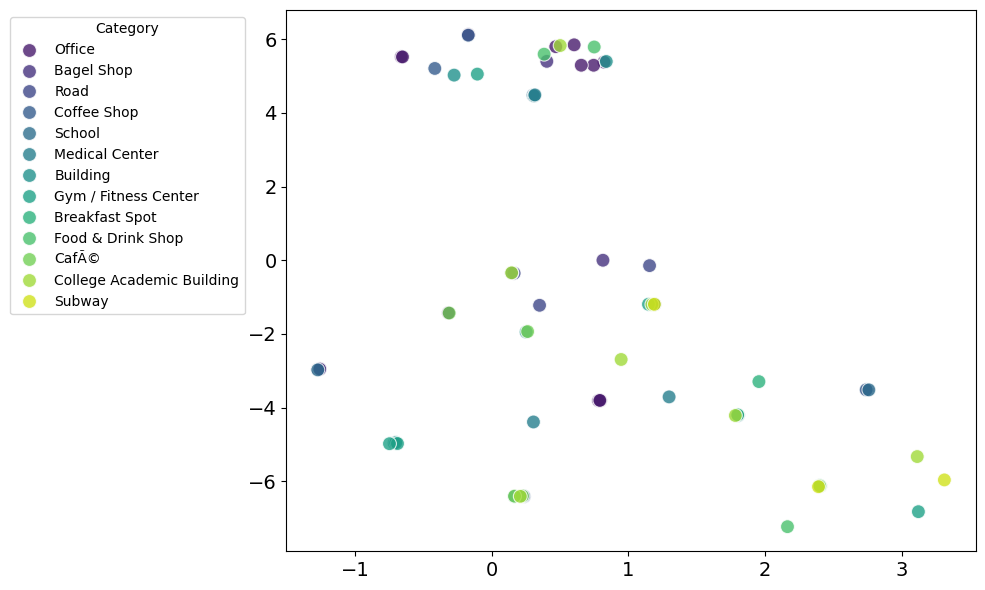

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 使用随机选择的前两层索引组合
selected_combos_for_tsne = selected_combos

# 检查 Vector 列是否已经是列表类型，避免重复 eval
if isinstance(codebook['Vector'].iloc[0], str):
    codebook['Vector'] = codebook['Vector'].apply(eval)

# 使用 selected_combos 中的4个组合
filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and (
        (x[0] == combo1[0] and x[1] == combo1[1]) or
        (x[0] == combo2[0] and x[1] == combo2[1]) or
        (x[0] == combo3[0] and x[1] == combo3[1]) or
        (x[0] == combo4[0] and x[1] == combo4[1])
    )
)] 
print(f"使用前两层索引组合 {selected_combos_for_tsne}, 共 {len(filtered_df)} 个 POI")

# 自动从四个组合的 top 5 categories 中收集所有category（去重）
all_cat_keys = []
for combo in selected_combos_for_tsne:
    combo_df = codebook[codebook['Codebook'].apply(
        lambda x: len(x) > 1 and x[0] == combo[0] and x[1] == combo[1]
    )]
    top_cats = combo_df['catname'].value_counts().head(5).index.tolist()
    for cat in top_cats:
        if cat not in all_cat_keys:
            all_cat_keys.append(cat)
print(f"自动收集到 {len(all_cat_keys)} 个 categories: {all_cat_keys}")

filtered_df = filtered_df[['catname', 'Vector']]
filtered_df = filtered_df[filtered_df['catname'].isin(all_cat_keys)]
print(f"过滤后剩余 {len(filtered_df)} 个POI")

# 将 `Vector` 列转化为numpy数组，便于t-SNE处理
vectors = np.array(filtered_df['Vector'].to_list())

# 使用t-SNE进行降维到2维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectors)

# 将降维后的结果添加到DataFrame中
filtered_df['tsne_1'] = tsne_results[:, 0]
filtered_df['tsne_2'] = tsne_results[:, 1]

# 将 catname 映射到指定顺序并生成颜色
sorted_df = filtered_df[filtered_df['catname'].isin(all_cat_keys)].copy()
sorted_df['catname'] = pd.Categorical(sorted_df['catname'], categories=all_cat_keys, ordered=True)
sorted_df.sort_values('catname', inplace=True)

# 使用渐变调色板
num_categories = len(all_cat_keys)
palette = sns.color_palette("viridis", num_categories)

# 绘制 t-SNE 可视化
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=sorted_df,
    x='tsne_1',
    y='tsne_2',
    hue='catname',
    palette=palette,
    s=100,
    alpha=0.8,
    ax=ax
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(title='Category', bbox_to_anchor=(-0.05, 1), loc='upper right', fontsize=10)
ax.tick_params(axis='y', labelsize=14)  
ax.tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_tsne_cat_combo.png', dpi=600)
plt.show()


# 前两层 Prefix 组合对 Region 的分析

分析 codebook 前两层索引组合（[x[0], x[1]]）与 region_id 的关系


In [7]:
# ============================================================================
# 统计 codebook 前两层索引组合与region的关系
# (使用已经计算好的 frequency_combo 和 two_layer_combo)
# ============================================================================
print("\n📊 前两层索引组合与Region的关系统计:")
print("=" * 80)

# 统计排名前30的每个组合下，出现频率最高的前5个region
print("\n📊 排名前30的每个组合下，出现频率最高的前5个region:")
print("=" * 80)
top_30_combos_region = [c for c in frequency_combo.head(30).index.tolist() if c is not None]
groups_dict_combo_region = {}

for rank, combo in enumerate(top_30_combos_region, 1):
    filtered_df = codebook[codebook['Codebook'].apply(
        lambda x: len(x) > 1 and x[0] == combo[0] and x[1] == combo[1]
    )]
    top_regions = filtered_df['region_id'].value_counts().head(5)
    groups_dict_combo_region[combo] = top_regions.to_dict()
    
    print(f"\n排名 #{rank:2d}: 组合 [{combo[0]:2d}, {combo[1]:2d}] (共 {len(filtered_df):3d} 个 POI)")
    for i, (region, count) in enumerate(top_regions.items(), 1):
        print(f"    Top {i}: Region {region:3d} - {count:3d} 次")

print("\n" + "=" * 80 + "\n")



📊 前两层索引组合与Region的关系统计:

📊 排名前30的每个组合下，出现频率最高的前5个region:

排名 # 1: 组合 [ 2, 30] (共  36 个 POI)
    Top 1: Region  70 -   7 次
    Top 2: Region  56 -   5 次
    Top 3: Region  12 -   2 次
    Top 4: Region  60 -   2 次
    Top 5: Region  29 -   2 次

排名 # 2: 组合 [22, 10] (共  34 个 POI)
    Top 1: Region  70 -  10 次
    Top 2: Region  65 -   8 次
    Top 3: Region  56 -   5 次
    Top 4: Region  48 -   2 次
    Top 5: Region  90 -   1 次

排名 # 3: 组合 [12, 30] (共  32 个 POI)
    Top 1: Region  70 -   9 次
    Top 2: Region  60 -   3 次
    Top 3: Region  36 -   2 次
    Top 4: Region  65 -   2 次
    Top 5: Region  22 -   1 次

排名 # 4: 组合 [12, 24] (共  31 个 POI)
    Top 1: Region  70 -   5 次
    Top 2: Region  51 -   2 次
    Top 3: Region  65 -   2 次
    Top 4: Region  56 -   2 次
    Top 5: Region  22 -   2 次

排名 # 5: 组合 [ 5, 30] (共  28 个 POI)
    Top 1: Region  65 -  28 次

排名 # 6: 组合 [20, 24] (共  25 个 POI)
    Top 1: Region  56 -  11 次
    Top 2: Region  65 -   5 次
    Top 3: Region  70 -   4 次
    Top 4: Re

In [8]:
# ============================================================================
# 随机挑选 4 个前两层索引组合（threshold：最少出现18次）用于region分析
# ============================================================================
import random

# 筛选出现次数>=18的组合
frequent_combos_region = [combo for combo, count in frequency_combo.items() 
                          if combo is not None and count >= 15]

# random.seed(42)  # 取消注释可固定随机结果
selected_combos_region = random.sample(frequent_combos_region, k=4)

print("从前两层索引组合中随机挑选的4个组合（用于region分析）：")
for combo in selected_combos_region:
    print(f"组合 [{combo[0]}, {combo[1]}]")

# 生成 group_1 到 group_4，使用 selected_combos_region 中随机挑选的组合
combo1_r, combo2_r, combo3_r, combo4_r = selected_combos_region

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo1_r[0] and x[1] == combo1_r[1]
)]
group_1_combo_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"\n组合 [{combo1_r[0]}, {combo1_r[1]}] 的 top5 regions: {group_1_combo_region}")

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo2_r[0] and x[1] == combo2_r[1]
)]
group_2_combo_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"组合 [{combo2_r[0]}, {combo2_r[1]}] 的 top5 regions: {group_2_combo_region}")

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo3_r[0] and x[1] == combo3_r[1]
)]
group_3_combo_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"组合 [{combo3_r[0]}, {combo3_r[1]}] 的 top5 regions: {group_3_combo_region}")

filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and x[0] == combo4_r[0] and x[1] == combo4_r[1]
)]
group_4_combo_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"组合 [{combo4_r[0]}, {combo4_r[1]}] 的 top5 regions: {group_4_combo_region}")


从前两层索引组合中随机挑选的4个组合（用于region分析）：
组合 [3, 12]
组合 [2, 30]
组合 [29, 3]
组合 [12, 30]

组合 [3, 12] 的 top5 regions: {65: 4, 43: 3, 70: 2, 73: 1, 89: 1}
组合 [2, 30] 的 top5 regions: {70: 7, 56: 5, 12: 2, 60: 2, 29: 2}
组合 [29, 3] 的 top5 regions: {65: 8, 28: 2, 71: 1, 70: 1, 14: 1}
组合 [12, 30] 的 top5 regions: {70: 9, 60: 3, 36: 2, 65: 2, 22: 1}


共 14 个不同的 regions: [70, 60, 36, 65, 22, 43, 73, 89, 56, 12, 29, 28, 71, 14]


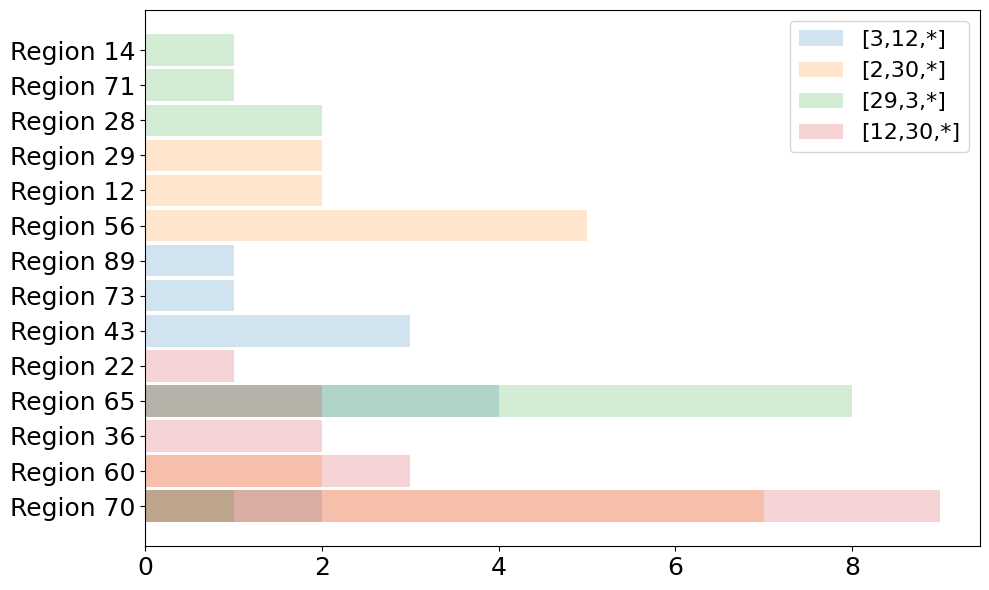

In [9]:
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = f'output/visualization/{target_path}'
os.makedirs(output_dir, exist_ok=True)

# 确保使用与上一个 Cell 相同的组合变量
combo1_r, combo2_r, combo3_r, combo4_r = selected_combos_region

# 合并所有的region keys
all_region_combo_keys = []
for group in [group_4_combo_region, group_1_combo_region, group_2_combo_region, group_3_combo_region]:
    for key in group.keys():
        if key not in all_region_combo_keys:
            all_region_combo_keys.append(key)
print(f"共 {len(all_region_combo_keys)} 个不同的 regions: {all_region_combo_keys}")

# 获取每个region在各组中的value（若某region不在某组中，视为0）
group_1_values = [group_1_combo_region.get(key, 0) for key in all_region_combo_keys]
group_2_values = [group_2_combo_region.get(key, 0) for key in all_region_combo_keys]
group_3_values = [group_3_combo_region.get(key, 0) for key in all_region_combo_keys]
group_4_values = [group_4_combo_region.get(key, 0) for key in all_region_combo_keys]

# 设置条形图位置
x = np.arange(len(all_region_combo_keys))

# 设置条形图宽度和透明度
bar_width = 0.9
alpha = 0.2

# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每一组的条形图（使用前两层索引组合）
rects1 = ax.barh(x, group_1_values, bar_width, label=f'[{combo1_r[0]},{combo1_r[1]},*]', alpha=alpha)
rects2 = ax.barh(x, group_2_values, bar_width, label=f'[{combo2_r[0]},{combo2_r[1]},*]', alpha=alpha)
rects3 = ax.barh(x, group_3_values, bar_width, label=f'[{combo3_r[0]},{combo3_r[1]},*]', alpha=alpha)
rects4 = ax.barh(x, group_4_values, bar_width, label=f'[{combo4_r[0]},{combo4_r[1]},*]', alpha=alpha)

# 添加标签和标题
ax.set_yticks(x)
ax.set_yticklabels([f"Region {r}" for r in all_region_combo_keys], fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.legend(fontsize=16)

# 显示图形
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_bar_region_combo.png', dpi=600)
plt.show()


# 第一层 Prefix 对 Region 的分析（新增）

分析 codebook 第一层索引（x[0]）与 region_id 的关系


In [45]:
# ============================================================================
# 统计第一层索引与region的关系
# ============================================================================
print("\n📊 第一层索引与Region的关系统计:")
print("=" * 80)

# 提取第一层索引
first_layer_indices = codebook['Codebook'].apply(lambda x: x[0] if len(x) > 0 else None)

# 统计频率
frequency_first = first_layer_indices.value_counts().sort_values(ascending=False)

print(f"\n✅ 出现次数最多的前20个第一层索引:")
for idx, count in frequency_first.head(20).items():
    print(f"   索引 {idx:2d}: {count:4d} 次")

# 统计每个索引的top5 regions
print("\n📊 排名前20的第一层索引对应的top5 regions:")
print("=" * 80)
top_20_first = frequency_first.head(20).index.tolist()

for rank, idx in enumerate(top_20_first, 1):
    filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
    top_regions = filtered_df['region_id'].value_counts().head(5)
    
    print(f"\n排名 #{rank:2d}: 第一层索引 [{idx}] (共 {len(filtered_df):3d} 个 POI)")
    for i, (region, count) in enumerate(top_regions.items(), 1):
        print(f"    Top {i}: Region {region:3d} - {count:3d} 次")

print("\n" + "=" * 80)



📊 第一层索引与Region的关系统计:

✅ 出现次数最多的前20个第一层索引:
   索引  2:  265 次
   索引 12:  253 次
   索引 10:  229 次
   索引 22:  224 次
   索引 15:  220 次
   索引 20:  218 次
   索引  6:  205 次
   索引  9:  203 次
   索引  1:  191 次
   索引 29:  189 次
   索引  5:  183 次
   索引  3:  179 次
   索引 16:  167 次
   索引 14:  164 次
   索引 21:  160 次
   索引  4:  160 次
   索引  8:  155 次
   索引  7:  142 次
   索引 28:  140 次
   索引 25:  139 次

📊 排名前20的第一层索引对应的top5 regions:

排名 # 1: 第一层索引 [2] (共 265 个 POI)
    Top 1: Region  70 -  74 次
    Top 2: Region  65 -  45 次
    Top 3: Region  56 -  30 次
    Top 4: Region  12 -  11 次
    Top 5: Region  28 -  10 次

排名 # 2: 第一层索引 [12] (共 253 个 POI)
    Top 1: Region  70 -  55 次
    Top 2: Region  65 -  38 次
    Top 3: Region  56 -  22 次
    Top 4: Region   5 -  10 次
    Top 5: Region  60 -   9 次

排名 # 3: 第一层索引 [10] (共 229 个 POI)
    Top 1: Region  70 -  51 次
    Top 2: Region  65 -  51 次
    Top 3: Region  56 -  21 次
    Top 4: Region  76 -   8 次
    Top 5: Region  54 -   7 次

排名 # 4: 第一层索引 [22] (共 224 个 POI)
 

In [46]:
# ============================================================================
# 随机挑选4个第一层索引用于region分析
# ============================================================================
import random

# 筛选出现次数>=50的第一层索引
frequent_first_indices = [idx for idx, count in frequency_first.items() if count >= 50]

# random.seed(42)  # 可固定随机结果
selected_first_indices = random.sample(frequent_first_indices, k=4)

print("随机挑选的4个第一层索引（用于region分析）：")
for idx in selected_first_indices:
    print(f"  索引 [{idx}]")

# 生成每个索引的top5 regions
idx1_f, idx2_f, idx3_f, idx4_f = selected_first_indices

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1_f)]
group_1_first_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"\n索引 [{idx1_f}] 的 top5 regions: {group_1_first_region}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx2_f)]
group_2_first_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"索引 [{idx2_f}] 的 top5 regions: {group_2_first_region}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx3_f)]
group_3_first_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"索引 [{idx3_f}] 的 top5 regions: {group_3_first_region}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx4_f)]
group_4_first_region = filtered_df['region_id'].value_counts().head(5).to_dict()
print(f"索引 [{idx4_f}] 的 top5 regions: {group_4_first_region}")


随机挑选的4个第一层索引（用于region分析）：
  索引 [24]
  索引 [26]
  索引 [2]
  索引 [21]

索引 [24] 的 top5 regions: {65: 20, 56: 15, 70: 12, 12: 5, 21: 4}
索引 [26] 的 top5 regions: {65: 30, 70: 23, 28: 11, 56: 8, 54: 7}
索引 [2] 的 top5 regions: {70: 74, 65: 45, 56: 30, 12: 11, 28: 10}
索引 [21] 的 top5 regions: {70: 44, 65: 38, 56: 17, 28: 10, 60: 5}


共 8 个不同的 regions: [70, 65, 56, 28, 60, 12, 21, 54]


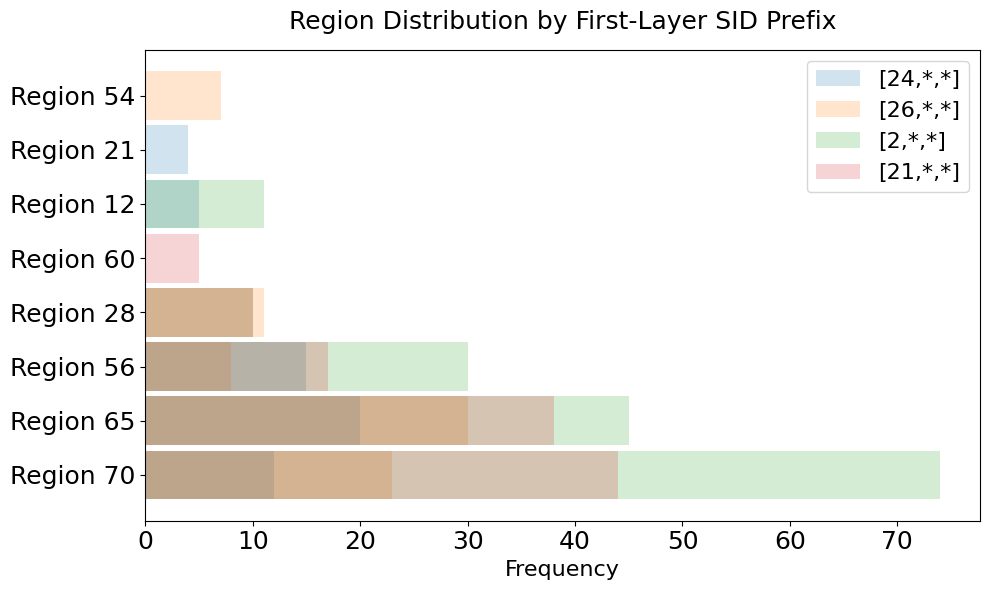

In [47]:
# ============================================================================
# 绘制第一层索引与region关系的条形图
# ============================================================================
import matplotlib.pyplot as plt

# 确保使用与上一个 Cell 相同的索引
idx1_f, idx2_f, idx3_f, idx4_f = selected_first_indices

# 合并所有region keys
all_region_first_keys = []
for group in [group_4_first_region, group_1_first_region, group_2_first_region, group_3_first_region]:
    for key in group.keys():
        if key not in all_region_first_keys:
            all_region_first_keys.append(key)
print(f"共 {len(all_region_first_keys)} 个不同的 regions: {all_region_first_keys}")

# 获取每个region在各组中的value
group_1_values = [group_1_first_region.get(key, 0) for key in all_region_first_keys]
group_2_values = [group_2_first_region.get(key, 0) for key in all_region_first_keys]
group_3_values = [group_3_first_region.get(key, 0) for key in all_region_first_keys]
group_4_values = [group_4_first_region.get(key, 0) for key in all_region_first_keys]

# 设置条形图
x = np.arange(len(all_region_first_keys))
bar_width = 0.9
alpha = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制条形图
rects1 = ax.barh(x, group_1_values, bar_width, label=f'[{idx1_f},*,*]', alpha=alpha)
rects2 = ax.barh(x, group_2_values, bar_width, label=f'[{idx2_f},*,*]', alpha=alpha)
rects3 = ax.barh(x, group_3_values, bar_width, label=f'[{idx3_f},*,*]', alpha=alpha)
rects4 = ax.barh(x, group_4_values, bar_width, label=f'[{idx4_f},*,*]', alpha=alpha)

# 添加标签
ax.set_yticks(x)
ax.set_yticklabels([f"Region {r}" for r in all_region_first_keys], fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.legend(fontsize=16)
ax.set_xlabel('Frequency', fontsize=16)
ax.set_title('Region Distribution by First-Layer SID Prefix', fontsize=18, pad=15)

plt.tight_layout()
plt.savefig(f'{output_dir}/first_layer_region_bar.png', dpi=600)
plt.show()


使用前两层索引组合 [(3, 12), (2, 30), (29, 3), (12, 30)], 共 100 个 POI
自动收集到 14 个 regions: [65, 43, 70, 73, 89, 56, 12, 60, 29, 28, 71, 14, 36, 22]
过滤后剩余 73 个POI


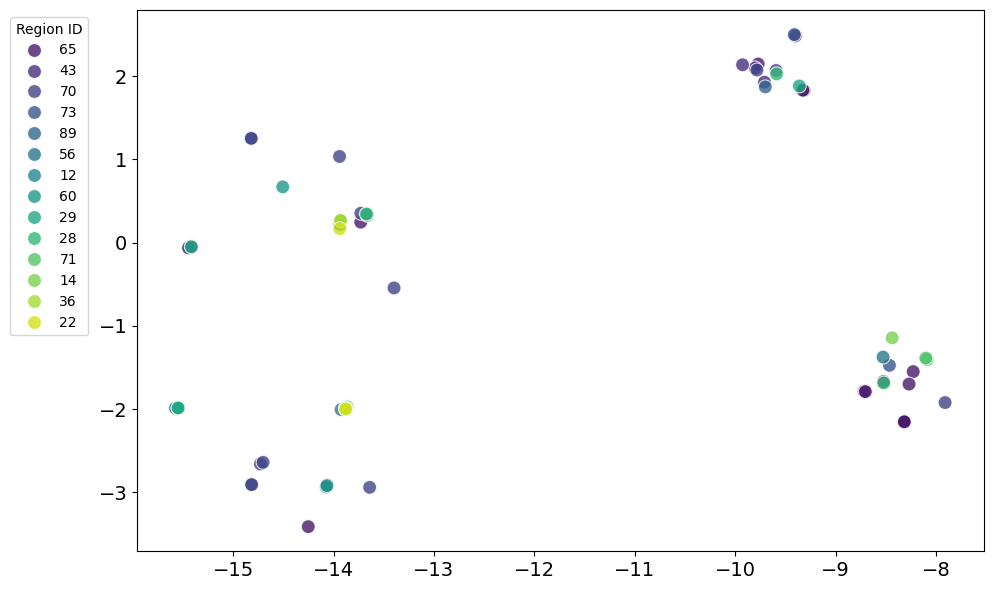

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 使用随机选择的前两层索引组合
selected_combos_for_region_tsne = selected_combos_region

# 检查 Vector 列是否已经是列表类型，避免重复 eval
if isinstance(codebook['Vector'].iloc[0], str):
    codebook['Vector'] = codebook['Vector'].apply(eval)

# 使用 selected_combos_region 中的4个组合
filtered_df = codebook[codebook['Codebook'].apply(
    lambda x: len(x) > 1 and (
        (x[0] == combo1_r[0] and x[1] == combo1_r[1]) or
        (x[0] == combo2_r[0] and x[1] == combo2_r[1]) or
        (x[0] == combo3_r[0] and x[1] == combo3_r[1]) or
        (x[0] == combo4_r[0] and x[1] == combo4_r[1])
    )
)] 
print(f"使用前两层索引组合 {selected_combos_for_region_tsne}, 共 {len(filtered_df)} 个 POI")

# 自动从四个组合的 top 5 regions 中收集所有region（去重）
all_region_combo_keys_tsne = []
for combo in selected_combos_for_region_tsne:
    combo_df = codebook[codebook['Codebook'].apply(
        lambda x: len(x) > 1 and x[0] == combo[0] and x[1] == combo[1]
    )]
    top_regions = combo_df['region_id'].value_counts().head(5).index.tolist()
    for region in top_regions:
        if region not in all_region_combo_keys_tsne:
            all_region_combo_keys_tsne.append(region)
print(f"自动收集到 {len(all_region_combo_keys_tsne)} 个 regions: {all_region_combo_keys_tsne}")

filtered_df = filtered_df[['region_id', 'Vector']]
filtered_df = filtered_df[filtered_df['region_id'].isin(all_region_combo_keys_tsne)]
print(f"过滤后剩余 {len(filtered_df)} 个POI")

# 将 `Vector` 列转化为numpy数组，便于t-SNE处理
vectors = np.array(filtered_df['Vector'].to_list())

# 使用t-SNE进行降维到2维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectors)

# 将降维后的结果添加到DataFrame中
filtered_df['tsne_1'] = tsne_results[:, 0]
filtered_df['tsne_2'] = tsne_results[:, 1]

# 将 region_id 映射到指定顺序并生成颜色
sorted_df = filtered_df[filtered_df['region_id'].isin(all_region_combo_keys_tsne)].copy()
sorted_df['region_id'] = pd.Categorical(sorted_df['region_id'], categories=all_region_combo_keys_tsne, ordered=True)
sorted_df.sort_values('region_id', inplace=True)

# 使用渐变调色板
num_regions = len(all_region_combo_keys_tsne)
palette = sns.color_palette("viridis", num_regions)

# 绘制 t-SNE 可视化
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=sorted_df,
    x='tsne_1',
    y='tsne_2',
    hue='region_id',
    palette=palette,
    s=100,
    alpha=0.8,
    ax=ax
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(title='Region ID', bbox_to_anchor=(-0.05, 1), loc='upper right', fontsize=10)
ax.tick_params(axis='y', labelsize=14)  
ax.tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_tsne_region_combo.png', dpi=600)
plt.show()


In [23]:
# ============================================================================
# 将指定的Plus Code转换回经纬度坐标
# ============================================================================
from openlocationcode import openlocationcode as olc
import pandas as pd

# 你提供的14个region映射（已补齐为10位完整格式，用最后一位字符重复）
region_data = [
    {"Mapped_Region": 70, "Original_Region": "87G8Q222+22"},
    {"Mapped_Region": 60, "Original_Region": "87G8R333+33"},
    {"Mapped_Region": 36, "Original_Region": "87G8Q777+77"},
    {"Mapped_Region": 65, "Original_Region": "87G8P222+22"},
    {"Mapped_Region": 22, "Original_Region": "87G8V444+44"},
    {"Mapped_Region": 43, "Original_Region": "87G8M333+33"},
    {"Mapped_Region": 73, "Original_Region": "87G8J222+22"},
    {"Mapped_Region": 89, "Original_Region": "87G7JXXX+XX"},
    {"Mapped_Region": 56, "Original_Region": "87G7PXXX+XX"},
    {"Mapped_Region": 12, "Original_Region": "87G8Q333+33"},
    {"Mapped_Region": 29, "Original_Region": "87G7QXXX+XX"},
    {"Mapped_Region": 28, "Original_Region": "87G8M222+22"},
    {"Mapped_Region": 71, "Original_Region": "87G8P666+66"},
    {"Mapped_Region": 14, "Original_Region": "87G8W444+44"},
]

print("🗺️  Plus Code → 经纬度转换结果")
print("=" * 120)
print(f"{'Region ID':<12} {'Plus Code':<15} {'中心纬度':<15} {'中心经度':<15} {'纬度范围':<25} {'经度范围':<25}")
print("=" * 120)

results = []
for item in region_data:
    region_id = item["Mapped_Region"]
    plus_code = item["Original_Region"]
    
    try:
        # 解码Plus Code
        code_area = olc.decode(plus_code)
        
        # 计算中心点坐标
        center_lat = (code_area.latitudeLo + code_area.latitudeHi) / 2
        center_lon = (code_area.longitudeLo + code_area.longitudeHi) / 2
        
        # 获取边界
        lat_range = f"[{code_area.latitudeLo:.6f}, {code_area.latitudeHi:.6f}]"
        lon_range = f"[{code_area.longitudeLo:.6f}, {code_area.longitudeHi:.6f}]"
        
        print(f"{region_id:<12} {plus_code:<15} {center_lat:<15.6f} {center_lon:<15.6f} {lat_range:<25} {lon_range:<25}")
        
        results.append({
            "Region_ID": region_id,
            "Plus_Code": plus_code,
            "Center_Latitude": center_lat,
            "Center_Longitude": center_lon,
            "Lat_Min": code_area.latitudeLo,
            "Lat_Max": code_area.latitudeHi,
            "Lon_Min": code_area.longitudeLo,
            "Lon_Max": code_area.longitudeHi,
            "Google_Maps": f"https://www.google.com/maps/search/?api=1&query={center_lat},{center_lon}"
        })
        
    except Exception as e:
        print(f"{region_id:<12} {plus_code:<15} Error: {e}")

print("=" * 120)

# 创建DataFrame便于查看
results_df = pd.DataFrame(results)
print("\n📊 转换结果汇总表:")
print(results_df[['Region_ID', 'Plus_Code', 'Center_Latitude', 'Center_Longitude']].to_string(index=False))

print("\n🌐 Google Maps 链接:")
for result in results:
    print(f"   Region {result['Region_ID']:3d} ({result['Plus_Code']}): {result['Google_Maps']}")


🗺️  Plus Code → 经纬度转换结果
Region ID    Plus Code       中心纬度            中心经度            纬度范围                      经度范围                     
70           87G8Q222+22     40.750062       -73.999938      [40.750000, 40.750125]    [-74.000000, -73.999875] 
60           87G8R333+33     40.802688       -73.947312      [40.802625, 40.802750]    [-73.947375, -73.947250] 
36           87G8Q777+77     40.763188       -73.736812      [40.763125, 40.763250]    [-73.736875, -73.736750] 
65           87G8P222+22     40.700063       -73.999938      [40.700000, 40.700125]    [-74.000000, -73.999875] 
22           87G8V444+44     40.855312       -73.894688      [40.855250, 40.855375]    [-73.894750, -73.894625] 
43           87G8M333+33     40.652687       -73.947312      [40.652625, 40.652750]    [-73.947375, -73.947250] 
73           87G8J222+22     40.600062       -73.999938      [40.600000, 40.600125]    [-74.000000, -73.999875] 
89           87G7JXXX+XX     40.649938       -74.000062      [40.649875,

   调整重叠点: Region 70 和 Region 56
   调整重叠点: Region 89 和 Region 28


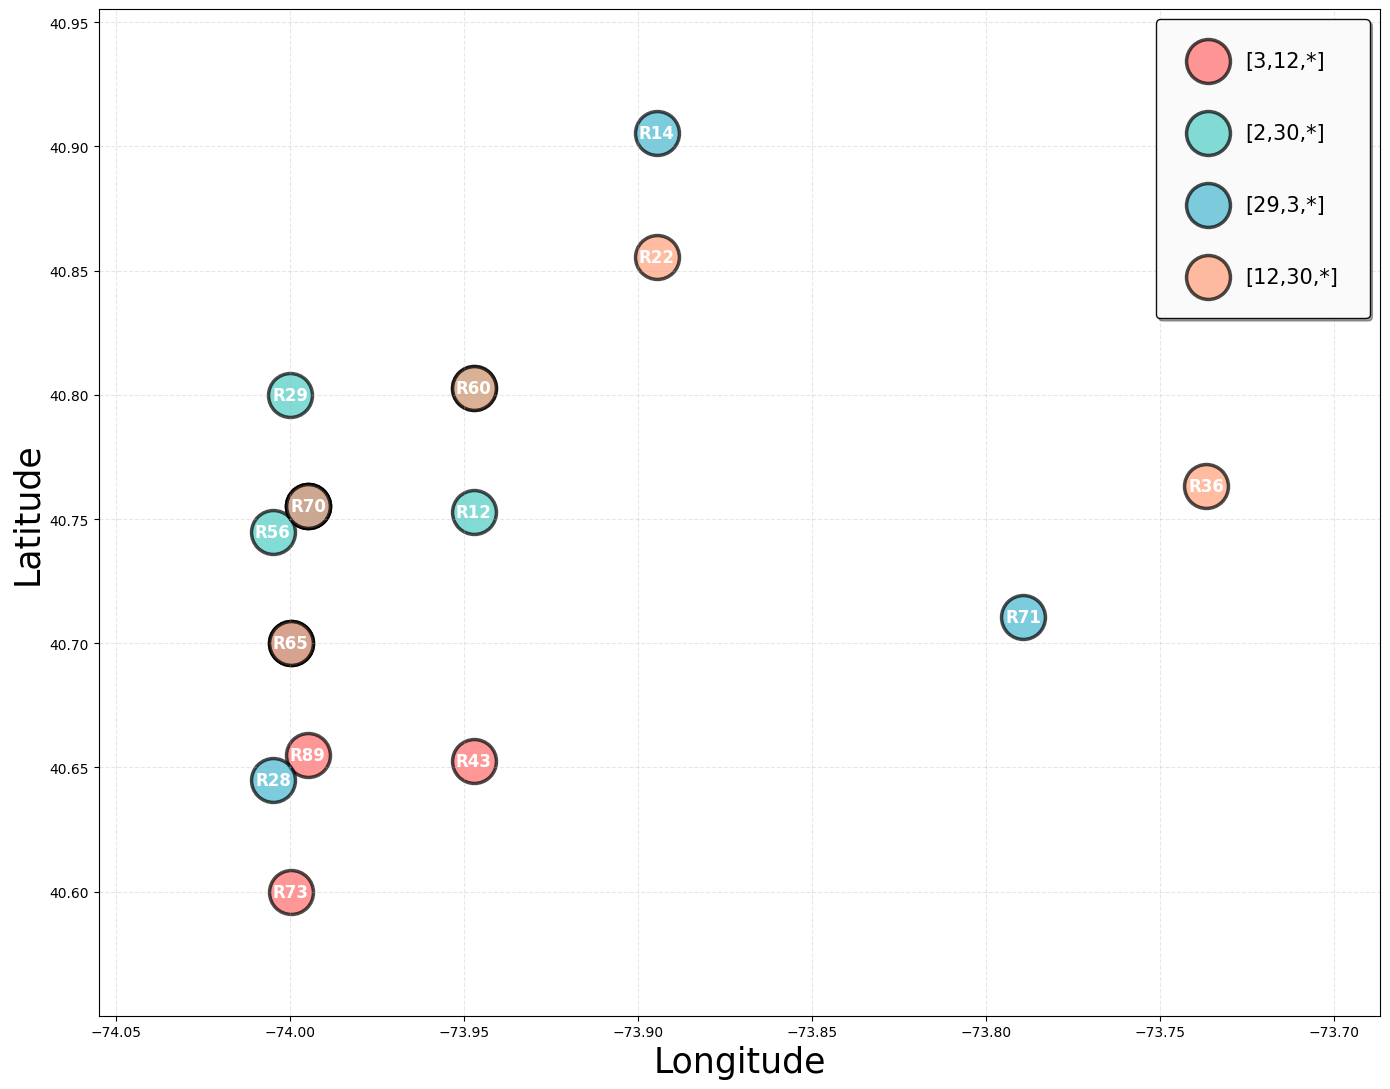


📍 地理分布统计:
   纬度范围: 40.6001° ~ 40.9053°
   经度范围: -74.0001° ~ -73.7368°
   覆盖区域: 约 33.9km (南北) × 22.1km (东西)

🎨 组合与Region对应关系:
   [3,12,*]: Regions [43, 65, 70, 73, 89]
   [2,30,*]: Regions [12, 29, 56, 60, 70]
   [29,3,*]: Regions [14, 28, 65, 70, 71]
   [12,30,*]: Regions [22, 36, 60, 65, 70]


In [48]:
# ============================================================================
# 可视化：在地图上标注这14个regions（按组合分配颜色）
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# 提取中心坐标
latitudes = [r['Center_Latitude'] for r in results]
longitudes = [r['Center_Longitude'] for r in results]
region_ids = [r['Region_ID'] for r in results]

# 检测并调整重叠的点
adjusted_lats = latitudes.copy()
adjusted_lons = longitudes.copy()

overlap_threshold = 0.01  # 如果距离小于这个值，认为重叠
offset = 0.005  # 偏移量

for i in range(len(adjusted_lats)):
    for j in range(i + 1, len(adjusted_lats)):
        # 计算两点之间的距离
        dist = np.sqrt((adjusted_lats[i] - adjusted_lats[j])**2 + 
                      (adjusted_lons[i] - adjusted_lons[j])**2)
        
        # 如果距离太近，进行调整
        if dist < overlap_threshold:
            # 沿对角线方向错开
            adjusted_lats[i] += offset
            adjusted_lons[i] += offset
            adjusted_lats[j] -= offset
            adjusted_lons[j] -= offset
            print(f"   调整重叠点: Region {region_ids[i]} 和 Region {region_ids[j]}")

# 定义4个组合及其对应的regions
combo_regions = {
    '[3,12,*]': {65, 43, 70, 73, 89},
    '[2,30,*]': {70, 56, 12, 60, 29},
    '[29,3,*]': {65, 28, 71, 70, 14},
    '[12,30,*]': {70, 60, 36, 65, 22},
}

# 为每个region分配主要组合（按出现频率，如果在多个组合中则取第一个）
region_to_combo = {}
combo_names = list(combo_regions.keys())
combo_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']  # 红、青、蓝、橙

for region_id in region_ids:
    for i, (combo_name, regions) in enumerate(combo_regions.items()):
        if region_id in regions:
            if region_id not in region_to_combo:
                region_to_combo[region_id] = (i, combo_name)
                break

# 为每个region分配颜色
colors = []
for rid in region_ids:
    if rid in region_to_combo:
        combo_idx, _ = region_to_combo[rid]
        colors.append(combo_colors[combo_idx])
    else:
        colors.append('gray')  # 不在任何组合中的region

# 创建散点图
fig, ax = plt.subplots(figsize=(14, 11))

# 按组合分别绘制散点，以便生成图例（使用调整后的坐标）
for i, (combo_name, regions) in enumerate(combo_regions.items()):
    # 筛选属于当前组合的regions（使用调整后的坐标）
    combo_lats = [lat for lat, rid in zip(adjusted_lats, region_ids) if rid in regions]
    combo_lons = [lon for lon, rid in zip(adjusted_lons, region_ids) if rid in regions]
    combo_rids = [rid for rid in region_ids if rid in regions]
    
    # 绘制当前组合
    ax.scatter(combo_lons, combo_lats, s=1000, c=combo_colors[i], 
               label=combo_name, alpha=0.7, edgecolors='black', linewidth=2.5)

# 添加region ID标签（使用调整后的坐标）
for lon, lat, rid in zip(adjusted_lons, adjusted_lats, region_ids):
    ax.annotate(f'R{rid}', (lon, lat), fontsize=12, ha='center', va='center', 
                fontweight='bold', color='white')

# 设置标题和标签
ax.set_xlabel('Longitude', fontsize=25)
ax.set_ylabel('Latitude', fontsize=25)

# 添加网格
ax.grid(True, alpha=0.3, linestyle='--')

# 添加图例（调整排列，增加标签间距）
ax.legend(loc='upper right', fontsize=15, framealpha=0.95, 
          ncol=1, borderpad=1.5, labelspacing=2.5,
          edgecolor='black', fancybox=True, shadow=True)

# 设置坐标轴范围（自动适应数据，使用调整后的坐标）
ax.set_xlim(min(adjusted_lons) - 0.05, max(adjusted_lons) + 0.05)
ax.set_ylim(min(adjusted_lats) - 0.05, max(adjusted_lats) + 0.05)

plt.tight_layout()
plt.savefig(f'{output_dir}/regions_map_by_combo.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📍 地理分布统计:")
print(f"   纬度范围: {min(latitudes):.4f}° ~ {max(latitudes):.4f}°")
print(f"   经度范围: {min(longitudes):.4f}° ~ {max(longitudes):.4f}°")
print(f"   覆盖区域: 约 {(max(latitudes)-min(latitudes))*111:.1f}km (南北) × {(max(longitudes)-min(longitudes))*111*np.cos(np.radians(np.mean(latitudes))):.1f}km (东西)")

print(f"\n🎨 组合与Region对应关系:")
for combo_name, regions in combo_regions.items():
    print(f"   {combo_name}: Regions {sorted(regions)}")


In [49]:
# ============================================================================
# 计算每个combo内部regions的平均距离
# ============================================================================
from itertools import combinations
import numpy as np

print("\n📏 计算每个Combo内部Region的平均距离:")
print("=" * 80)

# 创建region_id到坐标的映射（使用原始坐标，不是调整后的）
region_coords = {}
for rid, lat, lon in zip(region_ids, latitudes, longitudes):
    region_coords[rid] = (lat, lon)

# 对每个combo计算内部平均距离
for combo_name, regions in combo_regions.items():
    # 获取该combo中所有regions的坐标
    combo_coords = [(region_coords[rid][0], region_coords[rid][1]) 
                    for rid in regions if rid in region_coords]
    
    if len(combo_coords) < 2:
        print(f"\n{combo_name}:")
        print(f"   只有 {len(combo_coords)} 个region，无法计算距离")
        continue
    
    # 计算所有region对之间的距离
    distances = []
    region_pairs = []
    
    for i, (lat1, lon1) in enumerate(combo_coords):
        for j, (lat2, lon2) in enumerate(combo_coords):
            if i < j:  # 只计算一次每对region
                # 欧氏距离（度数）
                euclidean_dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
                
                # 转换为公里数（粗略估算）
                # 纬度1度 ≈ 111km
                # 经度1度 ≈ 111km * cos(纬度)
                avg_lat = (lat1 + lat2) / 2
                km_dist = np.sqrt(
                    ((lat1 - lat2) * 111)**2 + 
                    ((lon1 - lon2) * 111 * np.cos(np.radians(avg_lat)))**2
                )
                
                distances.append(km_dist)
                # 找出对应的region IDs
                rid1 = list(regions)[i]
                rid2 = list(regions)[j]
                region_pairs.append((rid1, rid2, km_dist))
    
    # 计算统计量
    avg_distance = np.mean(distances)
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    std_distance = np.std(distances)
    
    print(f"\n{combo_name}:")
    print(f"   Regions: {sorted(regions)}")
    print(f"   总计: {len(combo_coords)} 个regions, {len(distances)} 个region对")
    print(f"   平均距离: {avg_distance:.2f} km")
    print(f"   最小距离: {min_distance:.2f} km")
    print(f"   最大距离: {max_distance:.2f} km")
    print(f"   标准差:   {std_distance:.2f} km")
    
    # 显示距离最近和最远的region对
    region_pairs.sort(key=lambda x: x[2])
    print(f"   最近的两个regions: R{region_pairs[0][0]} ↔ R{region_pairs[0][1]} ({region_pairs[0][2]:.2f} km)")
    print(f"   最远的两个regions: R{region_pairs[-1][0]} ↔ R{region_pairs[-1][1]} ({region_pairs[-1][2]:.2f} km)")

print("\n" + "=" * 80)

# 计算所有combo的总体统计
print("\n📊 所有Combos的整体比较:")
all_avg_distances = []
for combo_name, regions in combo_regions.items():
    combo_coords = [(region_coords[rid][0], region_coords[rid][1]) 
                    for rid in regions if rid in region_coords]
    
    if len(combo_coords) >= 2:
        distances = []
        for i, (lat1, lon1) in enumerate(combo_coords):
            for j, (lat2, lon2) in enumerate(combo_coords):
                if i < j:
                    avg_lat = (lat1 + lat2) / 2
                    km_dist = np.sqrt(
                        ((lat1 - lat2) * 111)**2 + 
                        ((lon1 - lon2) * 111 * np.cos(np.radians(avg_lat)))**2
                    )
                    distances.append(km_dist)
        
        avg_dist = np.mean(distances)
        all_avg_distances.append((combo_name, avg_dist))
        print(f"   {combo_name:<25}: {avg_dist:>7.2f} km")

# 找出最紧凑和最分散的combo
all_avg_distances.sort(key=lambda x: x[1])
print(f"\n✅ 最紧凑的Combo (内部距离最小): {all_avg_distances[0][0]} ({all_avg_distances[0][1]:.2f} km)")
print(f"❌ 最分散的Combo (内部距离最大): {all_avg_distances[-1][0]} ({all_avg_distances[-1][1]:.2f} km)")

print("=" * 80)



📏 计算每个Combo内部Region的平均距离:

[3,12,*]:
   Regions: [43, 65, 70, 73, 89]
   总计: 5 个regions, 10 个region对
   平均距离: 8.59 km
   最小距离: 4.45 km
   最大距离: 16.65 km
   标准差:   3.70 km
   最近的两个regions: R89 ↔ R43 (4.45 km)
   最远的两个regions: R70 ↔ R73 (16.65 km)

[2,30,*]:
   Regions: [12, 29, 56, 60, 70]
   总计: 5 个regions, 10 个region对
   平均距离: 5.15 km
   最小距离: 0.02 km
   最大距离: 7.34 km
   标准差:   2.02 km
   最近的两个regions: R70 ↔ R56 (0.02 km)
   最远的两个regions: R56 ↔ R60 (7.34 km)

[29,3,*]:
   Regions: [14, 28, 65, 70, 71]
   总计: 5 个regions, 10 个region对
   平均距离: 17.40 km
   最小距离: 5.55 km
   最大距离: 29.68 km
   标准差:   7.51 km
   最近的两个regions: R65 ↔ R70 (5.55 km)
   最远的两个regions: R28 ↔ R14 (29.68 km)

[12,30,*]:
   Regions: [22, 36, 60, 65, 70]
   总计: 5 个regions, 10 个region对
   平均距离: 14.68 km
   最小距离: 5.55 km
   最大距离: 23.21 km
   标准差:   6.04 km
   最近的两个regions: R65 ↔ R70 (5.55 km)
   最远的两个regions: R65 ↔ R36 (23.21 km)


📊 所有Combos的整体比较:
   [3,12,*]                 :    8.59 km
   [2,30,*]                 :   